In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [2]:
# Using data augmentation for training
transform_train = transforms.Compose([
    transforms.Resize(224),  # Resize to match ResNet input
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training set size: {len(trainset)}")
print(f"Test set size: {len(testset)}")
print(f"Number of classes: {len(classes)}")

100%|██████████| 170M/170M [00:14<00:00, 12.0MB/s] 


Training set size: 50000
Test set size: 10000
Number of classes: 10


In [3]:
# Load pretrained ResNet-18 and modify for CIFAR-10
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers initially 
for param in model.parameters():
    param.requires_grad = False

# Remove the original classification layer (fc) and replace with new one for CIFAR-10
# Original fc layer: Linear(512, 1000) -> New: Linear(512, 10)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 10)

# Unfreeze the last few layers for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
model = model.to(device)

# Print model summary
print("Modified ResNet-18 for CIFAR-10:")
print(f"Input features to FC layer: {num_features}")
print(f"Output classes: 10")
print(f"\nTrainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Modified ResNet-18 for CIFAR-10:
Input features to FC layer: 512
Output classes: 10

Trainable parameters: 8,398,858


In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(test_loader), 100. * correct / total


In [6]:
# Fine-tune the model
num_epochs = 10
train_losses, train_accs = [], []
test_losses, test_accs = [], []

print(f"Starting fine-tuning for {num_epochs} epochs...")
print("=" * 60)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    # Step scheduler
    scheduler.step()
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("\n" + "=" * 60)
print("Training complete!")

Starting fine-tuning for 10 epochs...

Epoch 1/10


Evaluating: 100%|██████████| 157/157 [00:15<00:00, 10.26it/s]


Train Loss: 0.4609, Train Acc: 84.18%
Test Loss: 0.3478, Test Acc: 88.22%

Epoch 2/10


Evaluating: 100%|██████████| 157/157 [00:13<00:00, 11.43it/s]


Train Loss: 0.2982, Train Acc: 89.56%
Test Loss: 0.2907, Test Acc: 90.46%

Epoch 3/10


Evaluating: 100%|██████████| 157/157 [00:13<00:00, 11.45it/s]


Train Loss: 0.2324, Train Acc: 91.78%
Test Loss: 0.2592, Test Acc: 91.35%

Epoch 4/10


Evaluating: 100%|██████████| 157/157 [00:14<00:00, 10.80it/s]


Train Loss: 0.1968, Train Acc: 93.11%
Test Loss: 0.2759, Test Acc: 91.33%

Epoch 5/10


Evaluating: 100%|██████████| 157/157 [00:14<00:00, 10.87it/s]


Train Loss: 0.1630, Train Acc: 94.34%
Test Loss: 0.2492, Test Acc: 92.29%

Epoch 6/10


Evaluating: 100%|██████████| 157/157 [00:13<00:00, 11.46it/s]


Train Loss: 0.0941, Train Acc: 96.87%
Test Loss: 0.2009, Test Acc: 93.51%

Epoch 7/10


Evaluating: 100%|██████████| 157/157 [00:13<00:00, 11.80it/s]


Train Loss: 0.0716, Train Acc: 97.58%
Test Loss: 0.1960, Test Acc: 93.69%

Epoch 8/10


Evaluating: 100%|██████████| 157/157 [00:13<00:00, 11.76it/s]


Train Loss: 0.0590, Train Acc: 98.03%
Test Loss: 0.2019, Test Acc: 93.95%

Epoch 9/10


Evaluating: 100%|██████████| 157/157 [00:13<00:00, 11.30it/s]


Train Loss: 0.0489, Train Acc: 98.36%
Test Loss: 0.2083, Test Acc: 93.96%

Epoch 10/10


Evaluating: 100%|██████████| 157/157 [00:13<00:00, 11.24it/s]

Train Loss: 0.0413, Train Acc: 98.63%
Test Loss: 0.2077, Test Acc: 94.15%

Training complete!


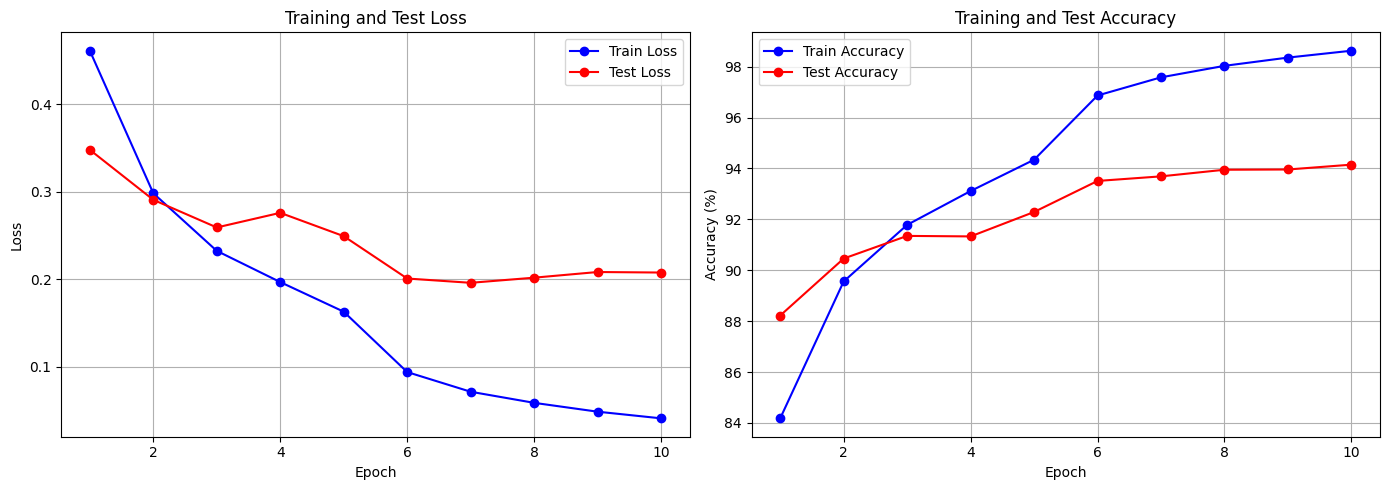


Best Test Accuracy: 94.15%


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(range(1, num_epochs+1), train_losses, 'b-o', label='Train Loss')
axes[0].plot(range(1, num_epochs+1), test_losses, 'r-o', label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy plot
axes[1].plot(range(1, num_epochs+1), train_accs, 'b-o', label='Train Accuracy')
axes[1].plot(range(1, num_epochs+1), test_accs, 'r-o', label='Test Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nBest Test Accuracy: {max(test_accs):.2f}%")

In [8]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'test_losses': test_losses,
    'train_accs': train_accs,
    'test_accs': test_accs,
}, 'resnet18_cifar10_finetuned.pth')

print("Model saved to 'resnet18_cifar10_finetuned.pth'")

Model saved to 'resnet18_cifar10_finetuned.pth'


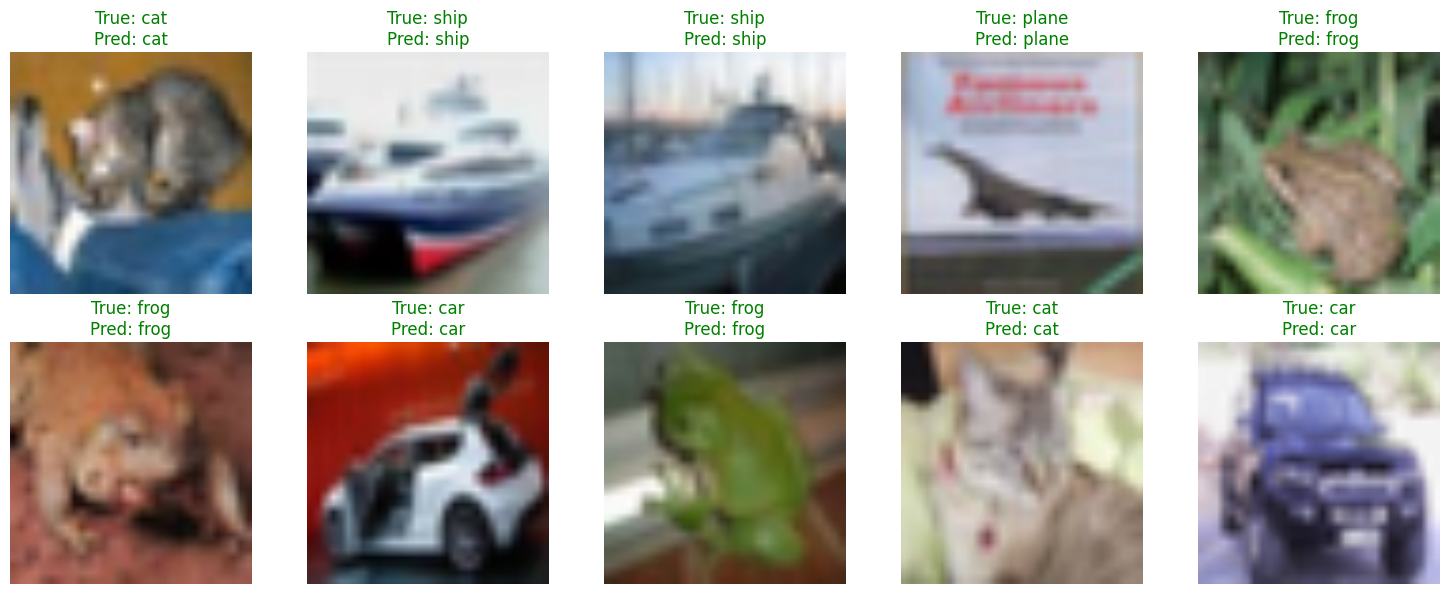

In [10]:
def imshow(img, title):
    # Unnormalize
    img = img.cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1) + np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Make predictions
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Show first 10 images with predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for idx, ax in enumerate(axes.flat):
    plt.sca(ax)
    img = images[idx]
    true_label = classes[labels[idx]]
    pred_label = classes[predicted[idx]]
    color = 'green' if labels[idx] == predicted[idx] else 'red'
    imshow(img, f'True: {true_label}\nPred: {pred_label}')
    ax.title.set_color(color)

plt.tight_layout()
plt.show()

INITIAL CONV LAYER (conv1) FILTERS
Shape: torch.Size([64, 3, 7, 7])
64 filters, 3 input channels (RGB), 7x7 kernel size



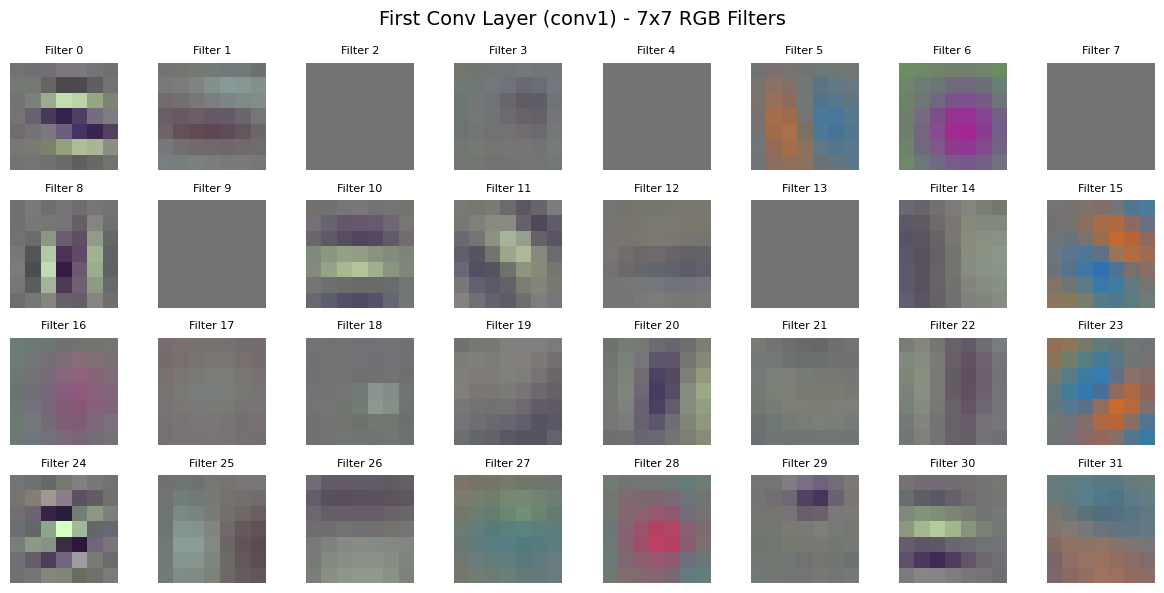


FINAL CONV LAYER (layer4.1.conv2) FILTERS
Shape: torch.Size([512, 512, 3, 3])
512 filters, 512 input channels, 3x3 kernel size



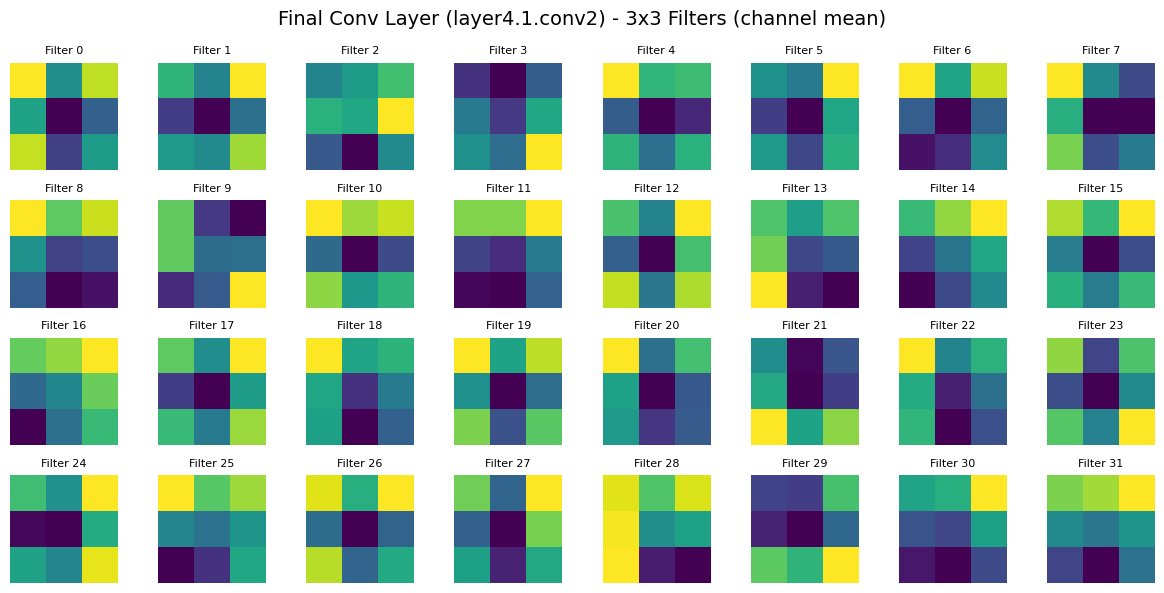

In [11]:
# Visualize learned filters from initial and final conv layers

def visualize_filters(weights, title, num_filters=16, cols=8):
    """
    Visualize convolutional filters
    weights: tensor of shape (out_channels, in_channels, H, W)
    """
    weights = weights.cpu().detach().clone()
    
    # Normalize weights to [0, 1] for visualization
    w_min, w_max = weights.min(), weights.max()
    weights = (weights - w_min) / (w_max - w_min + 1e-8)
    
    num_filters = min(num_filters, weights.shape[0])
    rows = (num_filters + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 1.5, rows * 1.5))
    fig.suptitle(title, fontsize=14)
    
    for idx, ax in enumerate(axes.flat):
        if idx < num_filters:
            # Get filter weights
            filt = weights[idx]
            
            # If filter has 3 input channels (RGB), display as color image
            if filt.shape[0] == 3:
                filt = filt.permute(1, 2, 0).numpy()  # (H, W, 3)
            else:
                # For multi-channel filters, take mean across input channels
                filt = filt.mean(dim=0).numpy()  # (H, W)
            
            ax.imshow(filt, cmap='viridis' if filt.ndim == 2 else None)
            ax.set_title(f'Filter {idx}', fontsize=8)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Extract and visualize filters from the FIRST conv layer (conv1)
print("=" * 60)
print("INITIAL CONV LAYER (conv1) FILTERS")
print("=" * 60)
first_conv_weights = model.conv1.weight.data
print(f"Shape: {first_conv_weights.shape}")  # (64, 3, 7, 7)
print(f"64 filters, 3 input channels (RGB), 7x7 kernel size\n")
visualize_filters(first_conv_weights, "First Conv Layer (conv1) - 7x7 RGB Filters", num_filters=32, cols=8)

# Extract and visualize filters from the FINAL conv layer (layer4's last conv)
print("\n" + "=" * 60)
print("FINAL CONV LAYER (layer4.1.conv2) FILTERS")
print("=" * 60)
# layer4 contains BasicBlocks, each with conv1 and conv2
final_conv_weights = model.layer4[1].conv2.weight.data
print(f"Shape: {final_conv_weights.shape}")  # (512, 512, 3, 3)
print(f"512 filters, 512 input channels, 3x3 kernel size\n")
visualize_filters(final_conv_weights, "Final Conv Layer (layer4.1.conv2) - 3x3 Filters (channel mean)", num_filters=32, cols=8)

Input image class: cat
Predicted class: cat

Feature maps shape: torch.Size([512, 7, 7])
Number of feature maps: 512
Feature map size: 7x7


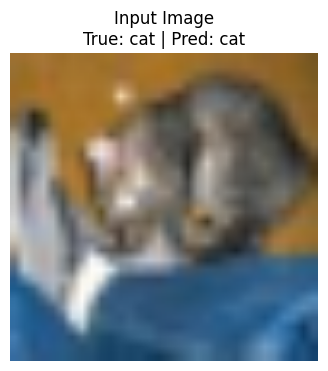

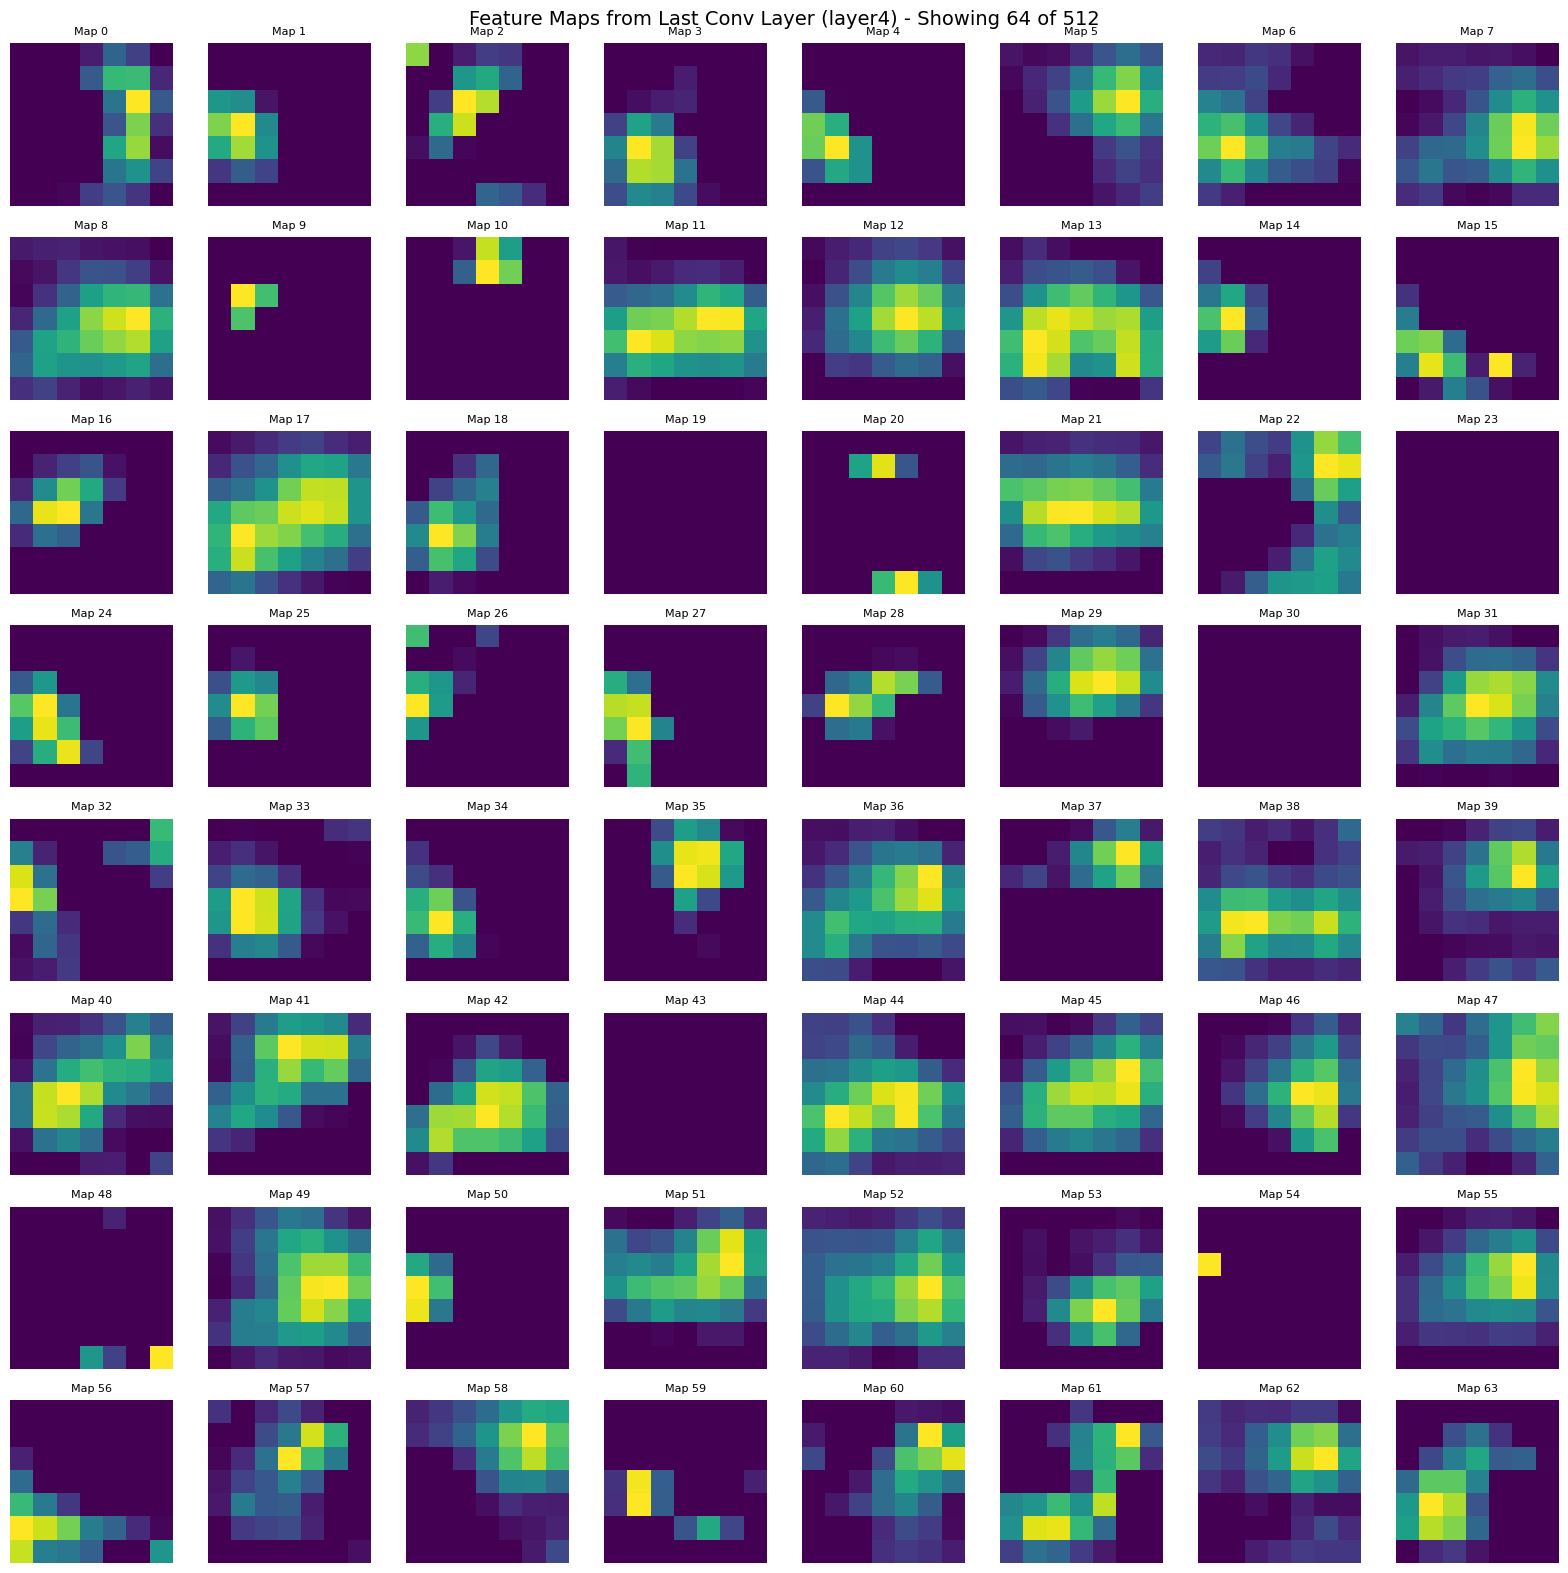

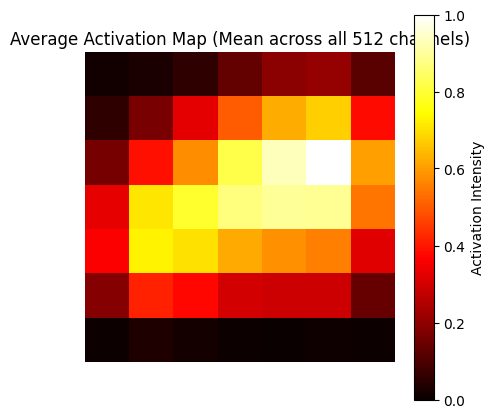

In [ ]:
activations = {}

# Hook function to capture activations
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hook on the last conv layer (layer4)
hook_handle = model.layer4.register_forward_hook(get_activation('layer4'))

# Get a test image
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[0:1].to(device)  
label = labels[0]

# Pass image through model
model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output, 1)

# Remove hook after use
hook_handle.remove()

# Get the feature maps from last conv layer
feature_maps = activations['layer4'].squeeze(0).cpu()  # Remove batch dim -> (512, 7, 7)

print(f"Input image class: {classes[label]}")
print(f"Predicted class: {classes[predicted.item()]}")
print(f"\nFeature maps shape: {feature_maps.shape}")
print(f"Number of feature maps: {feature_maps.shape[0]}")
print(f"Feature map size: {feature_maps.shape[1]}x{feature_maps.shape[2]}")

# Visualize the original image
plt.figure(figsize=(4, 4))
img_display = img.squeeze(0).cpu()
img_display = img_display * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
img_display = torch.clamp(img_display, 0, 1)
plt.imshow(img_display.permute(1, 2, 0).numpy())
plt.title(f"Input Image\nTrue: {classes[label]} | Pred: {classes[predicted.item()]}")
plt.axis('off')
plt.show()

# Visualize first 64 feature maps from layer4
num_maps = 64
cols = 8
rows = num_maps // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
fig.suptitle(f"Feature Maps from Last Conv Layer (layer4) - Showing {num_maps} of {feature_maps.shape[0]}", fontsize=14)

for idx, ax in enumerate(axes.flat):
    if idx < num_maps:
        # Normalize each feature map individually for better visualization
        fmap = feature_maps[idx].numpy()
        fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)
        ax.imshow(fmap, cmap='viridis')
        ax.set_title(f'Map {idx}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Also show the average activation across all feature maps
avg_activation = feature_maps.mean(dim=0).numpy()
avg_activation = (avg_activation - avg_activation.min()) / (avg_activation.max() - avg_activation.min() + 1e-8)

plt.figure(figsize=(5, 5))
plt.imshow(avg_activation, cmap='hot')
plt.colorbar(label='Activation Intensity')
plt.title("Average Activation Map (Mean across all 512 channels)")
plt.axis('off')
plt.show()

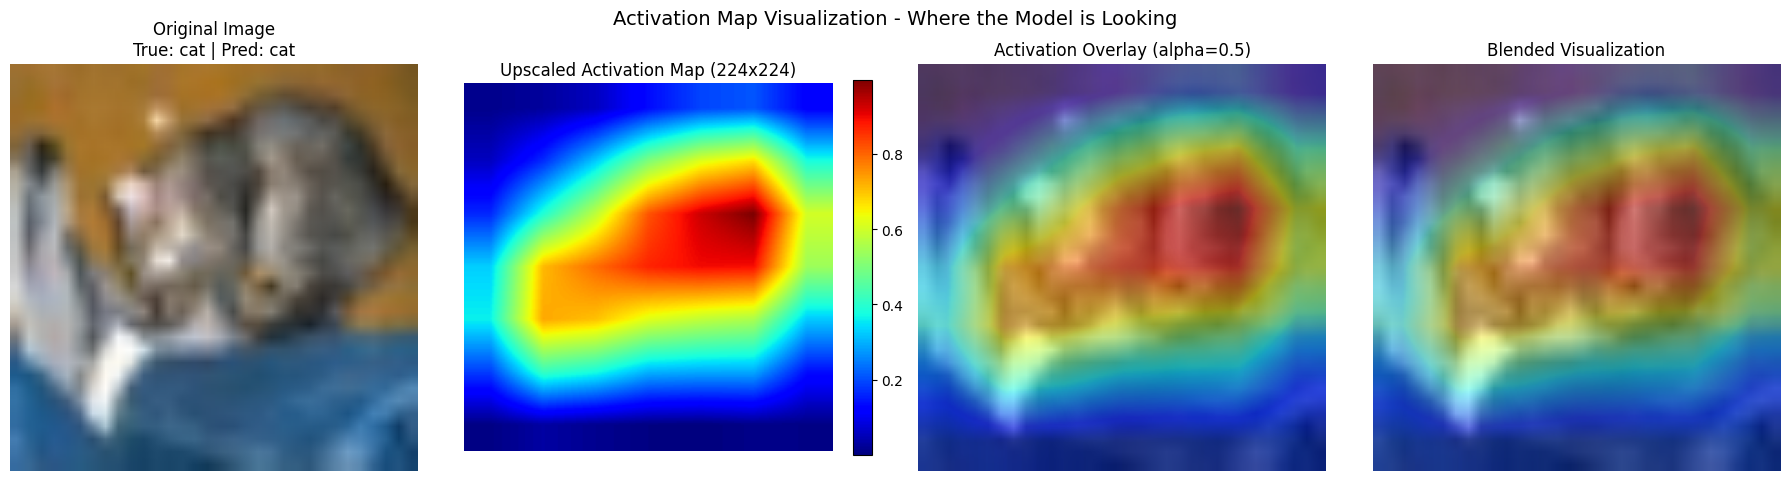

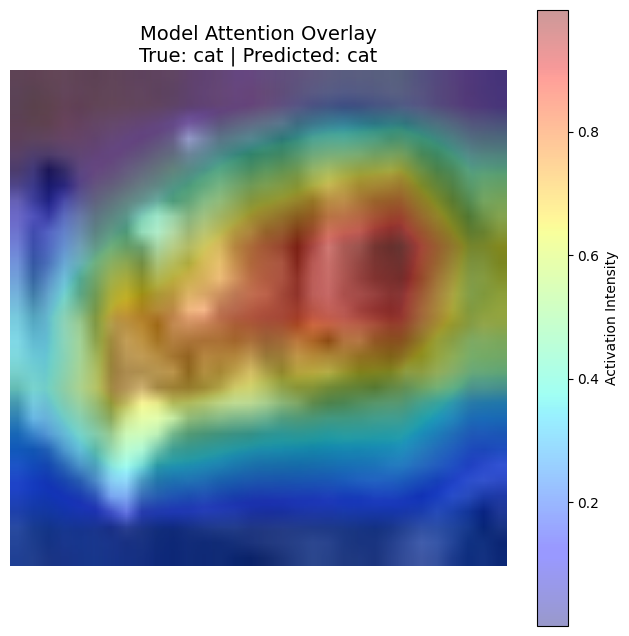

In [18]:
# Upscale activation map and overlay on original image
import torch.nn.functional as F

avg_activation = feature_maps.mean(dim=0)  # (7, 7)

avg_activation = (avg_activation - avg_activation.min()) / (avg_activation.max() - avg_activation.min() + 1e-8)

# Upscale to original image size (224x224) using bilinear interpolation
activation_upscaled = F.interpolate(
    avg_activation.unsqueeze(0).unsqueeze(0),  # Add batch and channel dims -> (1, 1, 7, 7)
    size=(224, 224),
    mode='bilinear',
    align_corners=False
).squeeze().numpy()  # Back to (224, 224)

img_display = img.squeeze(0).cpu()
img_display = img_display * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
img_display = torch.clamp(img_display, 0, 1).permute(1, 2, 0).numpy()

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# 1. Original image
axes[0].imshow(img_display)
axes[0].set_title(f"Original Image\nTrue: {classes[label]} | Pred: {classes[predicted.item()]}")
axes[0].axis('off')

# 2. Upscaled activation heatmap
im = axes[1].imshow(activation_upscaled, cmap='jet')
axes[1].set_title("Upscaled Activation Map (224x224)")
axes[1].axis('off')
plt.colorbar(im, ax=axes[1], fraction=0.046)

# 3. Overlay: activation map on original image
axes[2].imshow(img_display)
axes[2].imshow(activation_upscaled, cmap='jet', alpha=0.5)  # Semi-transparent overlay
axes[2].set_title("Activation Overlay (alpha=0.5)")
axes[2].axis('off')

# 4. Weighted blend for better visualization
heatmap = plt.cm.jet(activation_upscaled)[:, :, :3]  # Convert to RGB
blended = 0.6 * img_display + 0.4 * heatmap
blended = np.clip(blended, 0, 1)
axes[3].imshow(blended)
axes[3].set_title("Blended Visualization")
axes[3].axis('off')

plt.suptitle("Activation Map Visualization - Where the Model is Looking", fontsize=14)
plt.tight_layout()
plt.show()

# Also create a larger single overlay for better viewing
plt.figure(figsize=(8, 8))
plt.imshow(img_display)
plt.imshow(activation_upscaled, cmap='jet', alpha=0.4)
plt.colorbar(label='Activation Intensity')
plt.title(f"Model Attention Overlay\nTrue: {classes[label]} | Predicted: {classes[predicted.item()]}", fontsize=14)
plt.axis('off')
plt.show()

Total test images: 10000
Misclassified images: 585
Accuracy: 94.15%

First 20 misclassified image indices: [20, 37, 47, 57, 58, 59, 61, 68, 78, 118, 125, 162, 164, 178, 226, 232, 255, 265, 275, 277]


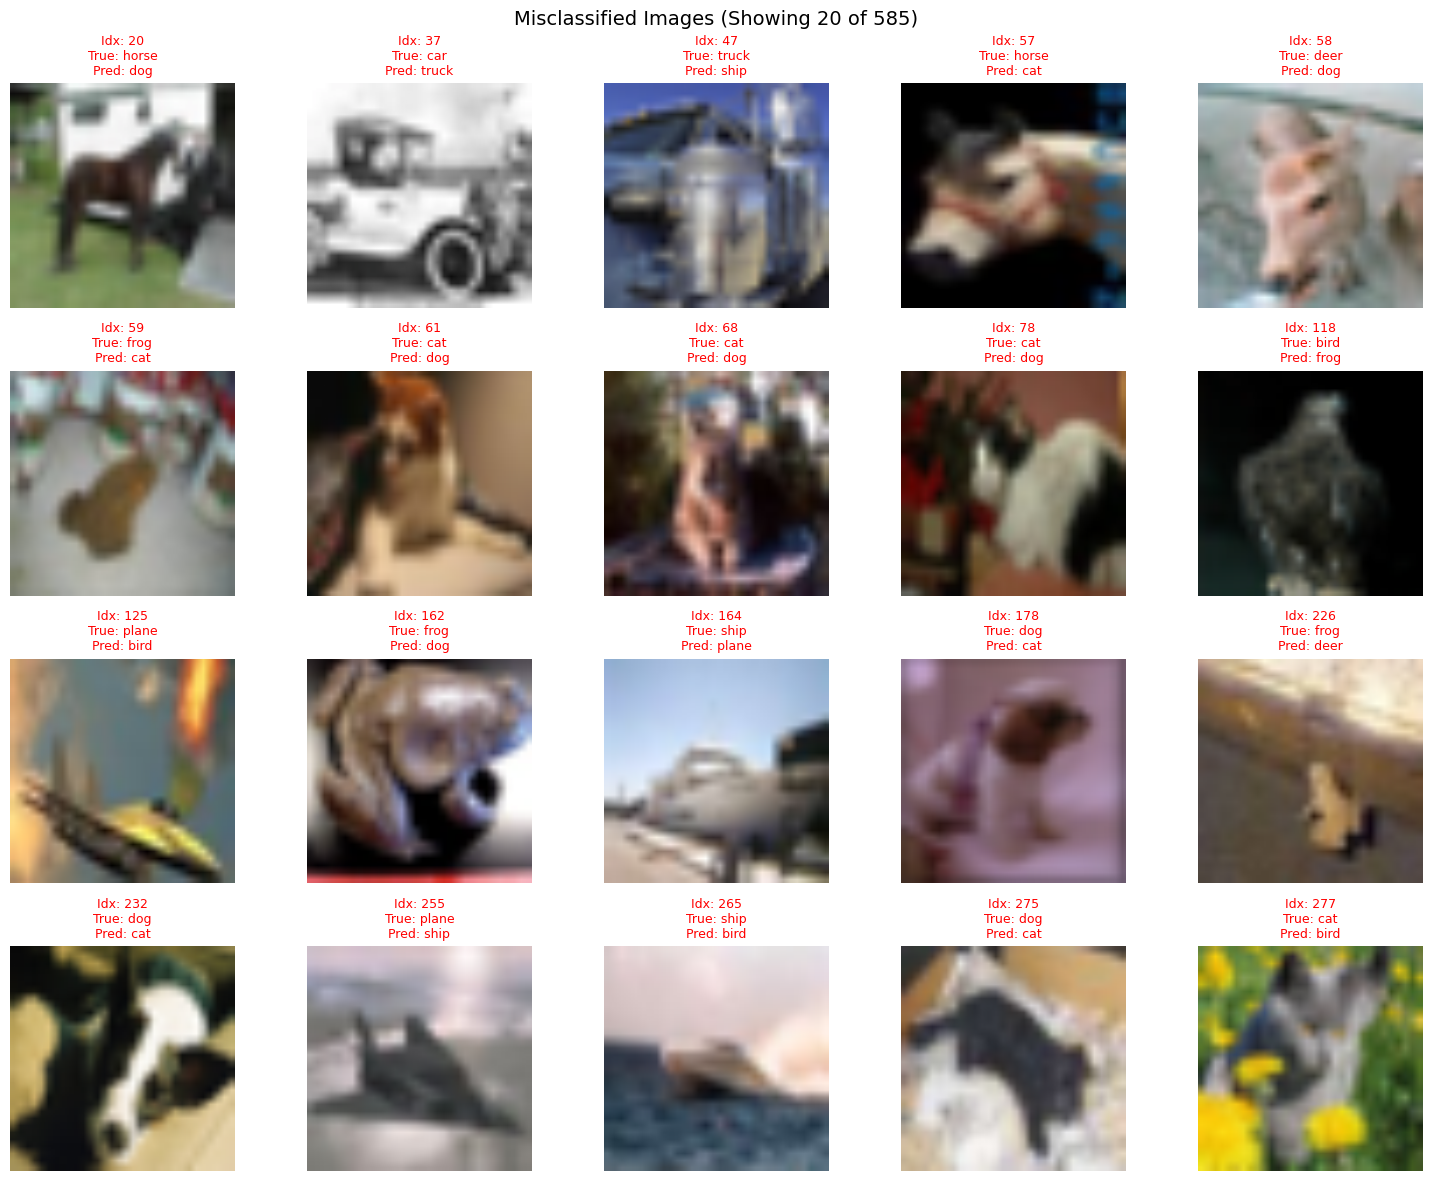


Top 10 Most Common Misclassifications:
----------------------------------------
     cat → dog     : 71 times
     dog → cat     : 71 times
     car → truck   : 26 times
   truck → car     : 26 times
    bird → cat     : 22 times
   plane → ship    : 17 times
   horse → dog     : 16 times
    ship → plane   : 16 times
     cat → bird    : 15 times
    frog → cat     : 14 times


In [31]:
# Find and display misclassified images with their indices

model.eval()
misclassified_images = []
misclassified_labels = []
misclassified_preds = []
misclassified_indices = []  # Store original indices in the test set

global_idx = 0  # Track position in entire test set

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Find indices where prediction != true label
        wrong_idx = (predicted != labels).nonzero(as_tuple=True)[0]
        
        for idx in wrong_idx:
            misclassified_images.append(images[idx].cpu())
            misclassified_labels.append(labels[idx].item())
            misclassified_preds.append(predicted[idx].item())
            misclassified_indices.append(global_idx + idx.item())  # Store global index
        
        global_idx += len(labels)

print(f"Total test images: {len(testset)}")
print(f"Misclassified images: {len(misclassified_images)}")
print(f"Accuracy: {100 * (1 - len(misclassified_images)/len(testset)):.2f}%")

# Print first 20 misclassified indices
print(f"\nFirst 20 misclassified image indices: {misclassified_indices[:20]}")

# Display first 20 misclassified images
num_display = min(20, len(misclassified_images))
cols = 5
rows = (num_display + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
fig.suptitle(f"Misclassified Images (Showing {num_display} of {len(misclassified_images)})", fontsize=14)

for idx, ax in enumerate(axes.flat):
    if idx < num_display:
        img = misclassified_images[idx]
        # Unnormalize
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()
        
        true_label = classes[misclassified_labels[idx]]
        pred_label = classes[misclassified_preds[idx]]
        test_idx = misclassified_indices[idx]
        
        ax.imshow(img)
        ax.set_title(f"Idx: {test_idx}\nTrue: {true_label}\nPred: {pred_label}", fontsize=9, color='red')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Show confusion breakdown
from collections import Counter
confusion_pairs = [(classes[t], classes[p]) for t, p in zip(misclassified_labels, misclassified_preds)]
common_mistakes = Counter(confusion_pairs).most_common(10)

print("\nTop 10 Most Common Misclassifications:")
print("-" * 40)
for (true_class, pred_class), count in common_mistakes:
    print(f"{true_class:>8} → {pred_class:<8}: {count} times")

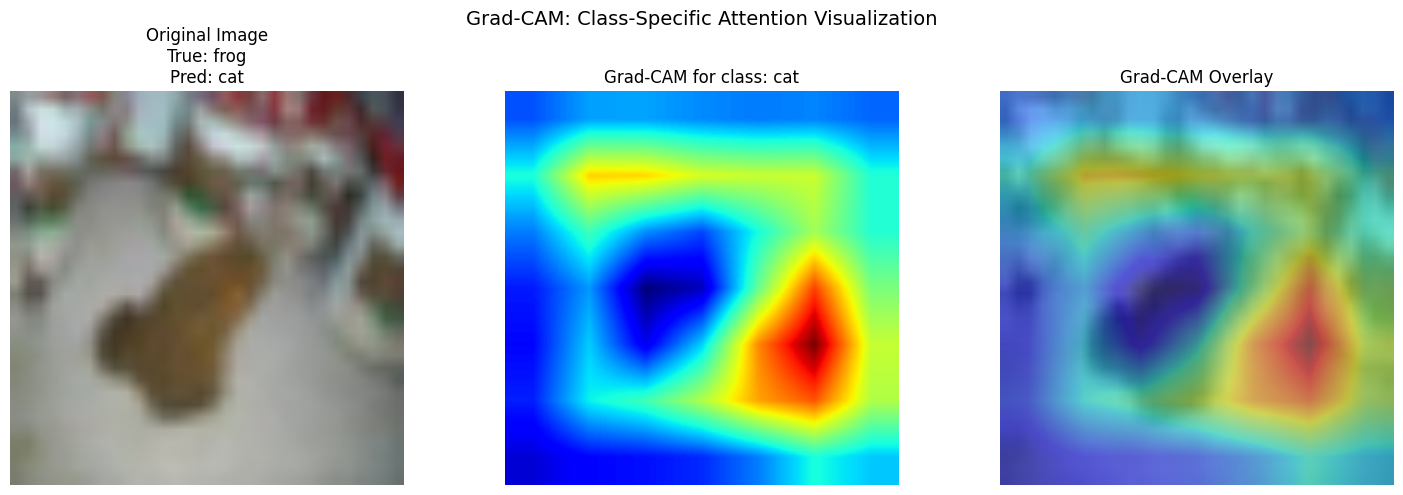

In [45]:
# Grad-CAM Implementation

gradients = {}
activations = {}

def save_gradient(name):
    def hook(grad):
        gradients[name] = grad.detach()
    return hook

def save_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
        output.register_hook(save_gradient(name))
    return hook

# Register hook
hook_handle = model.layer4.register_forward_hook(save_activation('layer4'))

# Get a test image
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[59:60].to(device)
label = labels[59]

# Forward pass (need gradients, so no torch.no_grad())
model.eval()
output = model(img)
_, predicted = torch.max(output, 1)

# Backward pass for the predicted class
model.zero_grad()
target_class = predicted.item() 
one_hot = torch.zeros_like(output)
one_hot[0, target_class] = 1
output.backward(gradient=one_hot)

hook_handle.remove()

# Get activations and gradients
acts = activations['layer4'].squeeze(0)  # (512, 7, 7)
grads = gradients['layer4'].squeeze(0)   # (512, 7, 7)

# Compute Grad-CAM weights (global average pooling of gradients)
weights = grads.mean(dim=(1, 2))  # (512,)

# Weighted combination of feature maps
grad_cam = torch.zeros(acts.shape[1:], device=device)  # (7, 7)
for i, w in enumerate(weights):
    grad_cam += w * acts[i]

# ReLU to keep only positive influences
grad_cam = torch.relu(grad_cam)
grad_cam = grad_cam.cpu()

# Normalize
grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min() + 1e-8)

# Upscale to image size
grad_cam_upscaled = F.interpolate(
    grad_cam.unsqueeze(0).unsqueeze(0),
    size=(224, 224),
    mode='bilinear',
    align_corners=False
).squeeze().numpy()

# Visualize
img_display = img.squeeze(0).cpu()
img_display = img_display * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
img_display = torch.clamp(img_display, 0, 1).permute(1, 2, 0).numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_display)
axes[0].set_title(f"Original Image\nTrue: {classes[label]}\nPred: {classes[predicted.item()]}")
axes[0].axis('off')

axes[1].imshow(grad_cam_upscaled, cmap='jet')
axes[1].set_title(f"Grad-CAM for class: {classes[target_class]}")
axes[1].axis('off')

axes[2].imshow(img_display)
axes[2].imshow(grad_cam_upscaled, cmap='jet', alpha=0.5)
axes[2].set_title("Grad-CAM Overlay")
axes[2].axis('off')

plt.suptitle("Grad-CAM: Class-Specific Attention Visualization", fontsize=14)
plt.tight_layout()
plt.show()

In [40]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  